In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Massachusetts

## VEST Documentation

Election results from Massachusetts Secretary of the Commonwealth (https://electionstats.state.ma.us/) Precinct shapefile from MassGIS Bureau of Geographic Information (https://docs.digital.mass.gov/dataset/massgis-data-wards-and-precincts)

A number of municipal boundaries were aligned with the more current MassGIS Town Survey shapefile.

The following precincts were split by congressional district to match reporting units: Andover 7; Bellingham 4; Cambridge 3-2; Fall River 5B,6C; Palmer 1; Raynham 1,2; Sudbury 1; Winchendon 1. Andover 9A was merged with Andover 1 by an act of the MA legislature prior to the 2020 election. The following precinct divisions are authorized and defined for voting purposes but not for redistricting purposes by specific acts of the MA legislature and were split accordingly: Chicopee 6A,6B; Dracut 6; Hingham 5; Newburyport 1; Peabody 4-3; Quincy 2-3; Revere 2-3,5-1,5-2. Warren A and Warren B precincts were split based on polling place assignments in the Warren parcel shapefile.

G20PREDBID - Joseph R. Biden (Democratic-Farmer-Labor Party)  
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Green Party)  
G20PREOWRI - Write-in Votes  

G20USSDMAR - Edward J. Markey (Democratic Party)  
G20USSROCO - Kevin J. O'Connor (Republican Party)  
G20USSOAYY - Shiva Ayyadurai (Write-in)  
G20USSOWRI - Other Write-in Votes  

## Import VEST file

In [2]:
vest_ma_20 = gp.read_file("./raw-from-source/VEST/ma_2020/ma_2020.shp")

In [3]:
data_columns = ['G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREOWRI',
       'G20USSDMAR', 'G20USSROCO', 'G20USSOAYY', 'G20USSOWRI']

## Load Source Files

In [4]:
all_files = os.listdir("./raw-from-source/Election_Results/")
li = []
for file in all_files:
    if file  != ".DS_Store":
        ref = "./raw-from-source/Election_Results/"
        file_ref = ref+file
        file_prev = pd.read_csv(file_ref,engine='python',index_col=None)
        #Only keep the City/Town and Pct columns in one file, as they are duplicated
        #Delete unused columns in others
        if file != 'PD43+__2020_President_General_Election_including_precincts.csv':
            file_prev = file_prev.drop(['City/Town', 'Ward', 'Pct','Blanks','Total Votes Cast'], axis=1)
            file_prev = file_prev.drop([0])
        else:
            file_prev = file_prev.drop(['Blanks','Total Votes Cast','No Preference'], axis=1)
            file_prev = file_prev.drop([0])
        for col in file_prev.columns:
            file_prev.rename(columns={col:col+"-"+file[12:len(file)-41]},inplace=True)
        li.append(file_prev)
    
#Define the dataframe, note we are add the loaded dataframes next to one another and not below
source_elections = pd.concat(li, axis=1, ignore_index=False)

In [5]:
#Rename columns to match VEST
source_elections.rename(columns={'City/Town-President':'City/Town', 'Ward-President':'Ward', 'Pct-President':'Pct',
       'Joseph R. Biden, Jr.-President':'G20PREDBID', 'Donald J. Trump-President':'G20PRERTRU',
       'Jo Jorgensen-President':'G20PRELJOR', 'Howard Hawkins-President':'G20PREGHAW',
       'All Others-President':'G20PREOWRI',
       'Edward J. Markey-U_S_Senate':'G20USSDMAR', "Kevin J. O'Connor-U_S_Senate":'G20USSROCO',
       'Shiva Ayyadurai-U_S_Senate':'G20USSOAYY', 'All Others-U_S_Senate':'G20USSOWRI'}
                       ,inplace=True)

In [6]:
source_elections.columns

Index(['City/Town', 'Ward', 'Pct', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR',
       'G20PREGHAW', 'G20PREOWRI', 'G20USSDMAR', 'G20USSROCO', 'G20USSOAYY',
       'G20USSOWRI'],
      dtype='object')

In [7]:
#Filter out "TOTALS"
source_elections = source_elections[source_elections["City/Town"]!="TOTALS"]

In [8]:
#Convert columns to numbers
for race in data_columns:
        source_elections[race]=source_elections[race].astype(str)
        source_elections[race]=source_elections[race].apply(lambda x: x.replace(',',''))
        source_elections[race]=source_elections[race].astype(float)
        source_elections[race]=source_elections[race].astype(int)

## Run Statewide Totals Check

In [9]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [10]:
statewide_totals_check(vest_ma_20,source_elections,data_columns)

***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 2382202
G20PRERTRU is equal 	VEST / RDH: 1167202
G20PRELJOR is equal 	VEST / RDH: 47013
G20PREGHAW is equal 	VEST / RDH: 18658
G20PREOWRI is equal 	VEST / RDH: 16327
G20USSDMAR is equal 	VEST / RDH: 2357809
G20USSROCO is equal 	VEST / RDH: 1177765
G20USSOAYY is equal 	VEST / RDH: 21134
G20USSOWRI is equal 	VEST / RDH: 7428


## Skip County Totals Check - No County Field in VEST Data

In [11]:
print(vest_ma_20)

                                 WP_NAME  WARD PRECINCT DISTRICT         TOWN  \
0       Fitchburg City Ward 2 Precinct A     2        A      2-A    FITCHBURG   
1              Dartmouth Town Precinct 7  None        7        7    DARTMOUTH   
2              Dartmouth Town Precinct 8  None        8        8    DARTMOUTH   
3              Dartmouth Town Precinct 9  None        9        9    DARTMOUTH   
4                 Dennis Town Precinct 1  None        1        1       DENNIS   
...                                  ...   ...      ...      ...          ...   
2168         Easthampton Town Precinct 2  None        2        2  EASTHAMPTON   
2169              Hadley Town Precinct 1  None        1        1       HADLEY   
2170  Northampton City Ward 1 Precinct A     1        A      1-A  NORTHAMPTON   
2171             Hingham Town Precinct 5  None        5        5      HINGHAM   
2172             Hingham Town Precinct 3  None        3        3      HINGHAM   

      TOWN_ID  G20PREDBID  

## Precinct by Precinct Check

In [12]:
#Define a district column
source_elections["DISTRICT"]=np.where(source_elections["Ward"]=="-",source_elections["Pct"],source_elections["Ward"]+"-"+source_elections["Pct"])

In [13]:
#Create join columns in both files
vest_ma_20["join_col"]=vest_ma_20["TOWN"]+"-"+vest_ma_20["DISTRICT"]
source_elections["join_col"] = source_elections["City/Town"].str.upper()+"-"+source_elections["DISTRICT"]

In [14]:
#Confirm they are unique
print(vest_ma_20["join_col"].value_counts(dropna=False))
print(source_elections["join_col"].value_counts(dropna=False))

FALMOUTH-4            1
SAUGUS-9              1
WEYMOUTH-4            1
NEWBURYPORT-4-1       1
HATFIELD-1            1
                     ..
NORTHBOROUGH-1        1
BOURNE-1              1
EAST BRIDGEWATER-4    1
CAMBRIDGE-6-1         1
ROCKLAND-3            1
Name: join_col, Length: 2173, dtype: int64
FALMOUTH-4       1
BOSTON-15-3      1
PEMBROKE-3       1
QUINCY-3-5       1
GROVELAND-1      1
                ..
BOURNE-1         1
CAMBRIDGE-6-1    1
BOSTON-11-3      1
RAYNHAM-1        1
ROCKLAND-3       1
Name: join_col, Length: 2173, dtype: int64


In [15]:
#Attempt to join
first_attempt = pd.merge(vest_ma_20,source_elections,how="outer",on="join_col",indicator=True)
print(first_attempt["_merge"].value_counts())

both          2114
left_only       59
right_only      59
Name: _merge, dtype: int64


In [16]:
#Fix unjoined precincts
source_name_changes_dict = {'E. BRIDGEWATER-1':'EAST BRIDGEWATER-1',
'E. BRIDGEWATER-2':'EAST BRIDGEWATER-2',
'E. BRIDGEWATER-3':'EAST BRIDGEWATER-3',
'E. BRIDGEWATER-4':'EAST BRIDGEWATER-4',
'E. BROOKFIELD-1':'EAST BROOKFIELD-1',
'E. LONGMEADOW-1':'EAST LONGMEADOW-1',
'E. LONGMEADOW-2':'EAST LONGMEADOW-2',
'E. LONGMEADOW-3':'EAST LONGMEADOW-3',
'E. LONGMEADOW-4':'EAST LONGMEADOW-4',
'MANCHESTER-BY-THE-SEA-1':'MANCHESTER-1',
'N. ADAMS-1-1':'NORTH ADAMS-1-1',
'N. ADAMS-2-2':'NORTH ADAMS-2-2',
'N. ADAMS-3-3':'NORTH ADAMS-3-3',
'N. ADAMS-4-4':'NORTH ADAMS-4-4',
'N. ADAMS-5-5':'NORTH ADAMS-5-5',
'N. ANDOVER-1':'NORTH ANDOVER-1',
'N. ANDOVER-2':'NORTH ANDOVER-2',
'N. ANDOVER-3':'NORTH ANDOVER-3',
'N. ANDOVER-4':'NORTH ANDOVER-4',
'N. ANDOVER-5':'NORTH ANDOVER-5',
'N. ANDOVER-6':'NORTH ANDOVER-6',
'N. ANDOVER-7':'NORTH ANDOVER-7',
'N. ANDOVER-8':'NORTH ANDOVER-8',
'N. ATTLEBOROUGH-1':'NORTH ATTLEBOROUGH-1',
'N. ATTLEBOROUGH-2':'NORTH ATTLEBOROUGH-2',
'N. ATTLEBOROUGH-3':'NORTH ATTLEBOROUGH-3',
'N. ATTLEBOROUGH-4':'NORTH ATTLEBOROUGH-4',
'N. ATTLEBOROUGH-5':'NORTH ATTLEBOROUGH-5',
'N. ATTLEBOROUGH-6':'NORTH ATTLEBOROUGH-6',
'N. ATTLEBOROUGH-7':'NORTH ATTLEBOROUGH-7',
'N. ATTLEBOROUGH-8':'NORTH ATTLEBOROUGH-8',
'N. ATTLEBOROUGH-9':'NORTH ATTLEBOROUGH-9',
'N. BROOKFIELD-1':'NORTH BROOKFIELD-1',
'N. READING-1':'NORTH READING-1',
'N. READING-2':'NORTH READING-2',
'N. READING-3':'NORTH READING-3',
'N. READING-4':'NORTH READING-4',
'NEWBURYPORT-1-P':'NEWBURYPORT-1-1P',
'S. HADLEY-A':'SOUTH HADLEY-A',
'S. HADLEY-B':'SOUTH HADLEY-B',
'S. HADLEY-C':'SOUTH HADLEY-C',
'S. HADLEY-D':'SOUTH HADLEY-D',
'S. HADLEY-E':'SOUTH HADLEY-E',
'W. BOYLSTON-1':'WEST BOYLSTON-1',
'W. BOYLSTON-2':'WEST BOYLSTON-2',
'W. BRIDGEWATER-1':'WEST BRIDGEWATER-1',
'W. BRIDGEWATER-2':'WEST BRIDGEWATER-2',
'W. BROOKFIELD-1':'WEST BROOKFIELD-1',
'W. NEWBURY-1':'WEST NEWBURY-1',
'W. SPRINGFIELD-1':'WEST SPRINGFIELD-1',
'W. SPRINGFIELD-2':'WEST SPRINGFIELD-2',
'W. SPRINGFIELD-3':'WEST SPRINGFIELD-3',
'W. SPRINGFIELD-4':'WEST SPRINGFIELD-4',
'W. SPRINGFIELD-5':'WEST SPRINGFIELD-5',
'W. SPRINGFIELD-6':'WEST SPRINGFIELD-6',
'W. SPRINGFIELD-7':'WEST SPRINGFIELD-7',
'W. SPRINGFIELD-8':'WEST SPRINGFIELD-8',
'W. STOCKBRIDGE-1':'WEST STOCKBRIDGE-1',
'W. TISBURY-1':'WEST TISBURY-1'}

In [17]:
#Apply name changes to get the final joins
source_elections["join_col"] = source_elections["join_col"].map(source_name_changes_dict).fillna(source_elections["join_col"])

In [18]:
#Join them again
final_join = pd.merge(vest_ma_20,source_elections,how="outer",on="join_col",indicator=True)
final_join["_merge"].value_counts()

both          2173
left_only        0
right_only       0
Name: _merge, dtype: int64

In [19]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [20]:
precinct_votes_check(final_join[final_join["_merge"]=="both"],data_columns,True,"join_col",print_level=0)


There are  2173  total rows
0  of these rows have election result differences
2173  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]


## Shapefile Check

<AxesSubplot:>

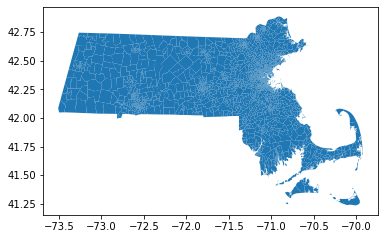

In [21]:
vest_ma_20.plot()

In [22]:
ma_check = gp.read_file("./raw-from-source/Shapefile/wardsprecincts_poly/WARDSPRECINCTS_POLY.shp")

<AxesSubplot:>

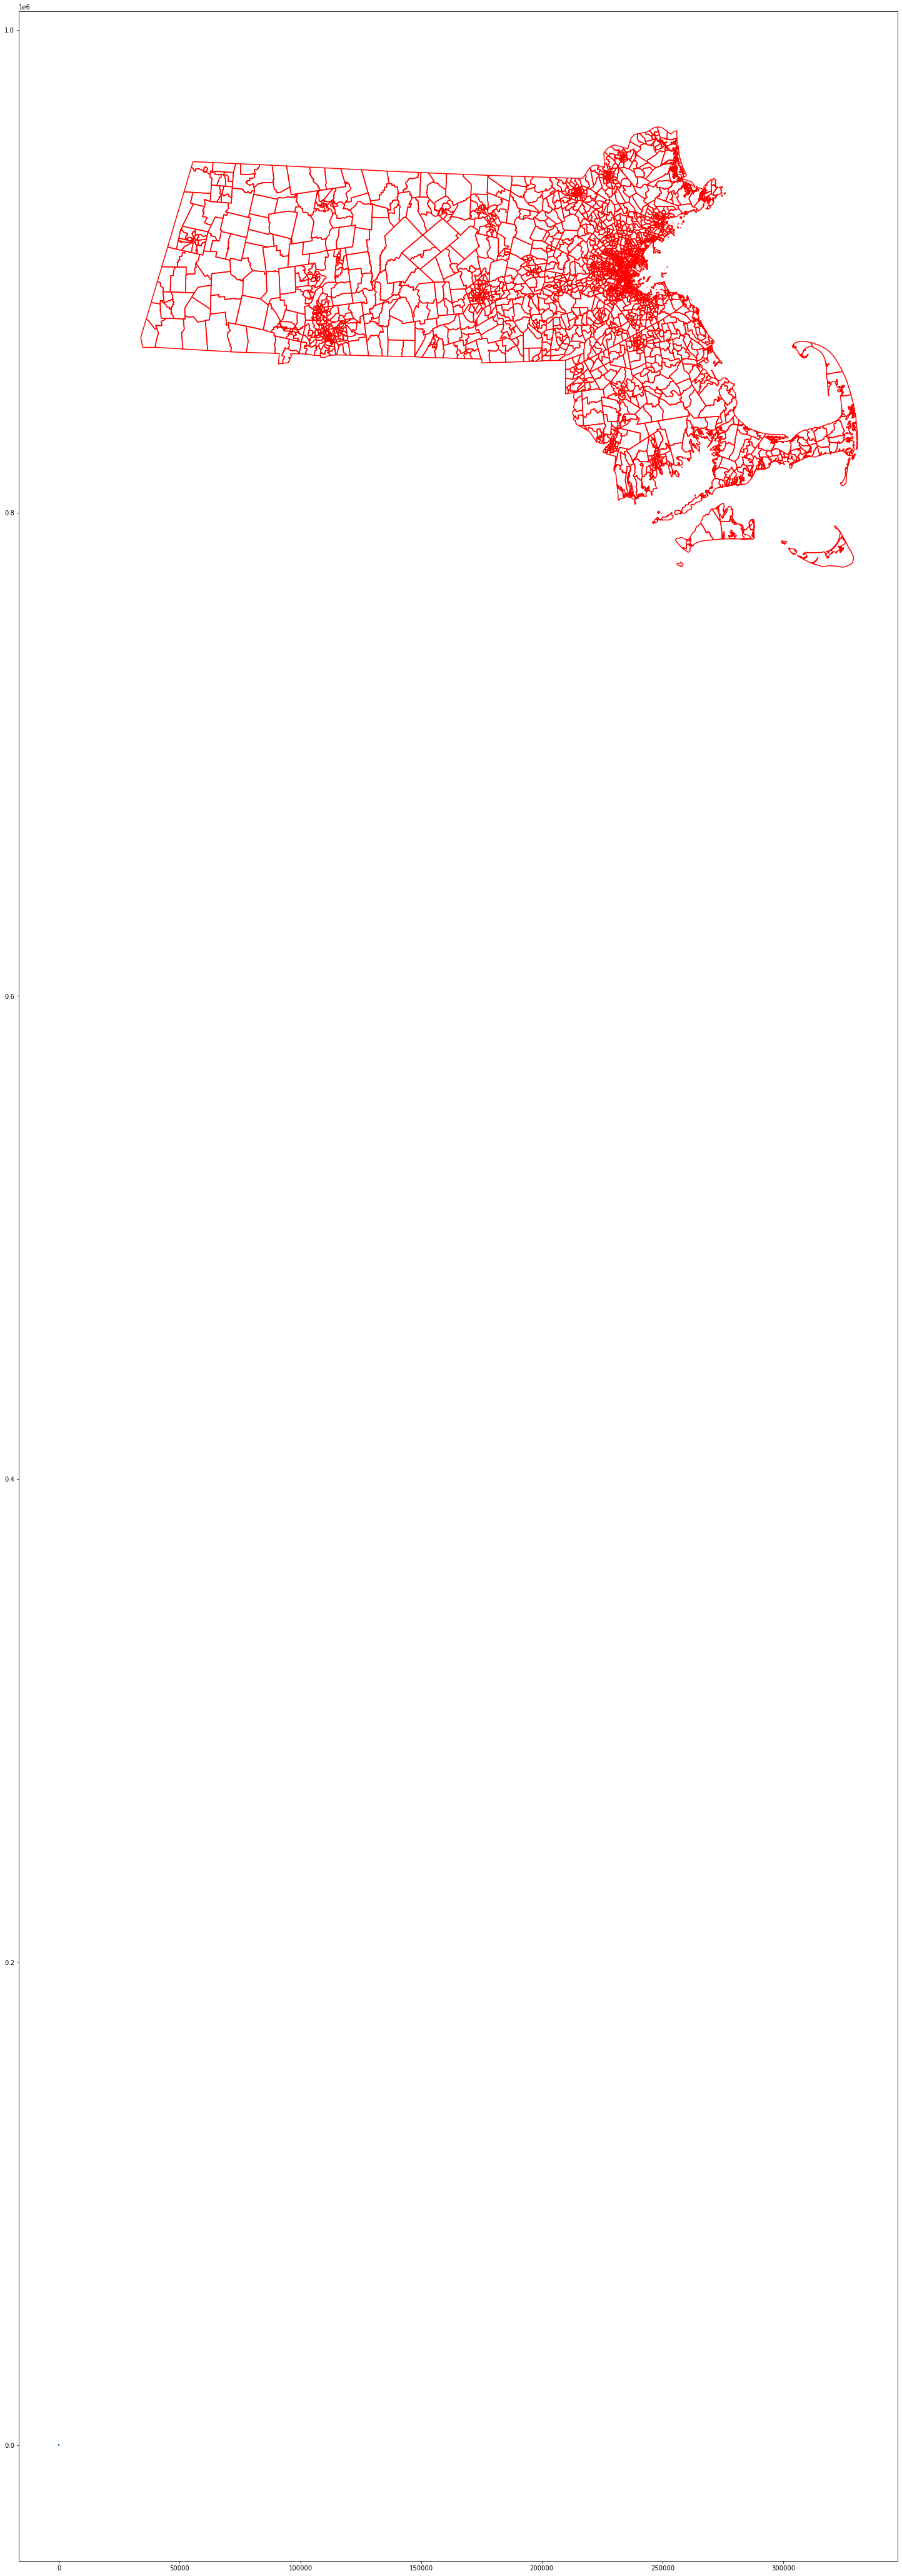

In [23]:
ax = vest_ma_20.boundary.plot(figsize=(75,75))
ma_check.boundary.plot(ax=ax,color="red")

<AxesSubplot:>

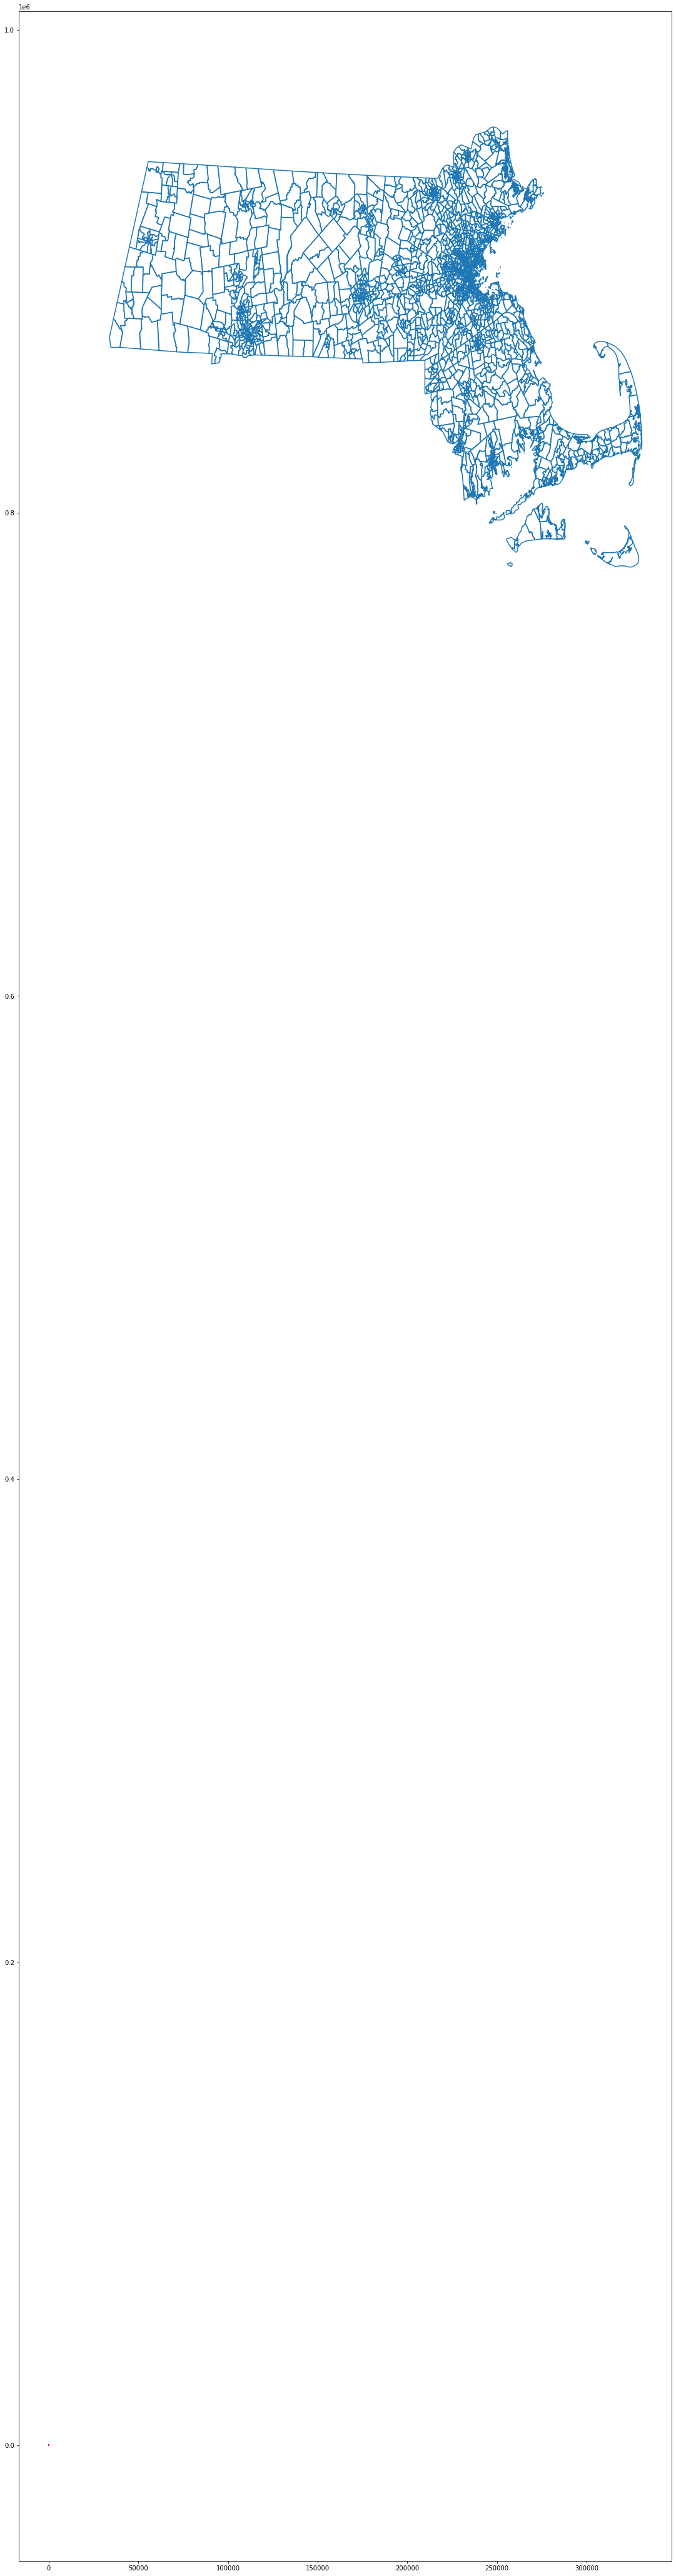

In [24]:
ax = ma_check.boundary.plot(figsize=(75,75))
vest_ma_20.boundary.plot(ax=ax,color="red")